# Automatic Image segmentation:

Let's consider an image segmentation problem in which we should identify a pattern from the background. In this case, we only have two classes of pixels: pixels belonging to the background and pixels belonging to the pattern of interest.

In order to understand the different methods covered in this session, we are going to use two different images from a well known dataset on retinal vessel segmentation:

- **Training image** ('vessels_train.jpg'): The one we are using in order to design the sementation method
- **Test iamge** ('vessels_test.jpg'): The image we are going to use in order to test the previously designed segmentation approach

For each of the images we also have their corresponding ground truth sementation images obtained from an independent expert ('vessels_train_GT.tif' and 'vessels_test_GT.tif'). We will use them as reference in order to quantify the performance of the sementation method. First we take a look to the image dataset: 

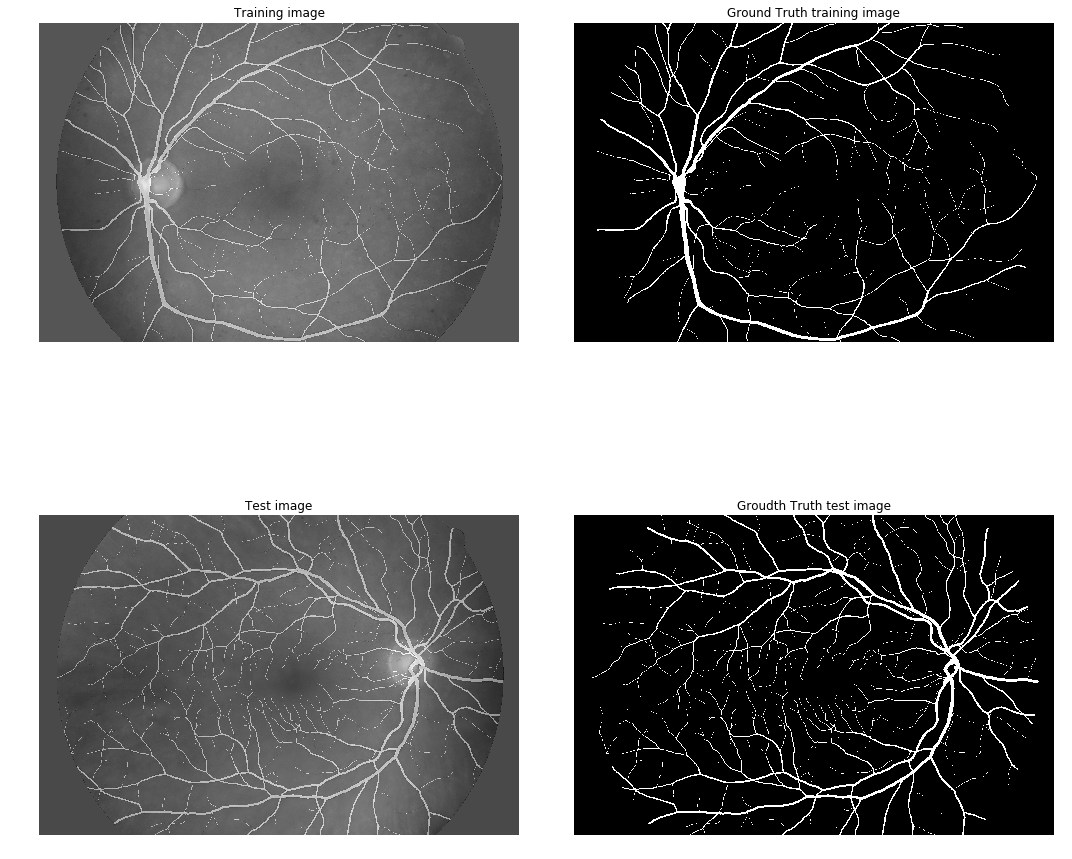

In [ ]:
import skimage as sk 
import matplotlib.pyplot as plt
from matplotlib import gridspec

I_train = sk.io.imread('vessels_train.jpg') 
I_train_GT = sk.io.imread('vessels_train_GT.tif') 
I_test = sk.io.imread('vessels_test.jpg') 
I_test_GT = sk.io.imread('vessels_test_GT.tif')

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(2, 2)

ax0 = fig.add_subplot(gs[0,0])
ax0.imshow(I_train, cmap=plt.cm.gray)
ax0.set_title('Training image')
ax0.set_axis_off()

ax1 = fig.add_subplot(gs[0,1])
ax1.imshow(I_train_GT, cmap=plt.cm.gray)
ax1.set_title('Ground Truth training image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[1,0])
ax2.imshow(I_test, cmap=plt.cm.gray)
ax2.set_title('Test image')
ax2.set_axis_off()

ax3 = fig.add_subplot(gs[1,1])
ax3.imshow(I_test_GT, cmap=plt.cm.gray)
ax3.set_title('Groudth Truth test image')
ax3.set_axis_off()

plt.tight_layout()
plt.show()

# Manual thresholding:

A straightforward segmentation approach would be setting a manual grayscale trheshold after inspection of the image histogram:

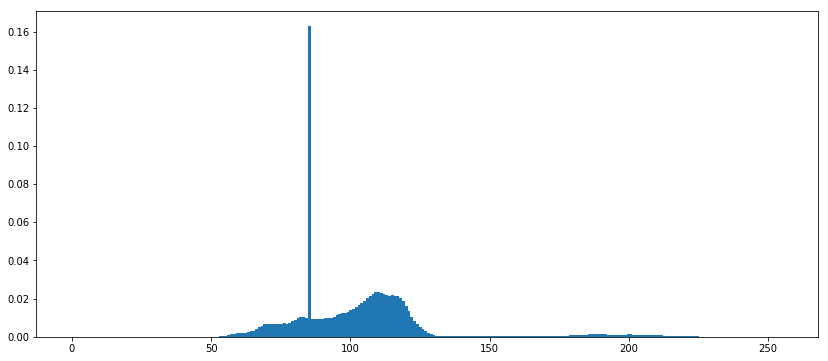

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

# reshape training image as 1d array:
v_I_train = I_train.reshape(I_train.shape[0]*I_train.shape[1],1).astype(np.uint8) 

fig = plt.figure(figsize=(14, 6))
plt.hist(v_I_train, bins=256,density=True)
plt.show()

since we observe two clear clusters in the histogram we can separate them using a threshold of around 150-160:

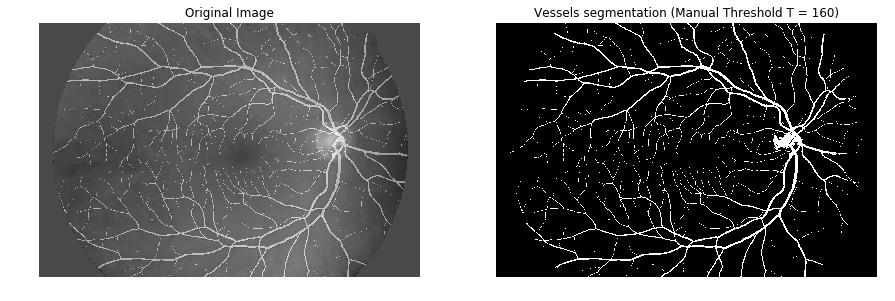

In [ ]:
# Find Otsu's threshold for training image:
threshold_manual = 160

# Apply manual threshold to test image (Image Binarization):
I_manual = I_test >= threshold_manual


fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(I_test, cmap=plt.cm.gray)
ax1.set_title('Original Image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(I_manual, cmap=plt.cm.gray)
ax2.set_title('Vessels segmentation (Manual Threshold T = {})'.format(threshold_manual))
ax2.set_axis_off()

plt.show()

## Otsu's Algorithm:

The first automatic segmentation approach is the Otsu's Method. 

otsu.png![image.png](attachment:image.png)

The algorithm finds the threshold that **maximum inter-class variance** $\sigma _{b}^{2}(t)$, defined in terms of the difference between the means of the two clusters in the image histogram (pattern and background, respectively):

$\sigma _{b}^{2}(t)=\omega _{0}(t)\omega _{1}(t)\left[\mu _{0}(t)-\mu _{1}(t)\right]^{2}$ 

The algorithm is the following: 

1. Compute histogram and probabilities of each intensity level $p(i), i=0,\dots L$ where $L=2^n$ for an n-bit grayscale image.

2. Set up initial $\omega _{i}(0)$ and $\mu _{i}(0)$ 

3. Step through all possible thresholds $t=1,\ldots L-1$ 

a) Update $\omega _{i}$ and $\mu _{i}$


$\omega _{0}(t)=\sum _{i=0}^{t-1}p(i)$

$\omega _{1}(t)=\sum _{i=t}^{L-1}p(i)$

$\mu _{0}(t)={\frac {\sum _{i=0}^{t-1}ip(i)}{\omega _{0}(t)}}$

$\mu _{1}(t)={\frac {\sum _{i=t}^{L-1}ip(i)}{\omega _{1}(t)}}$

b) Compute $\sigma _{b}^{2}(t)=\omega _{0}(t)\omega _{1}(t)\left[\mu _{0}(t)-\mu _{1}(t)\right]^{2}$ 

4. Desired threshold corresponds to the maximum inter-class variance $\sigma _{b}^{2}(t)$ 

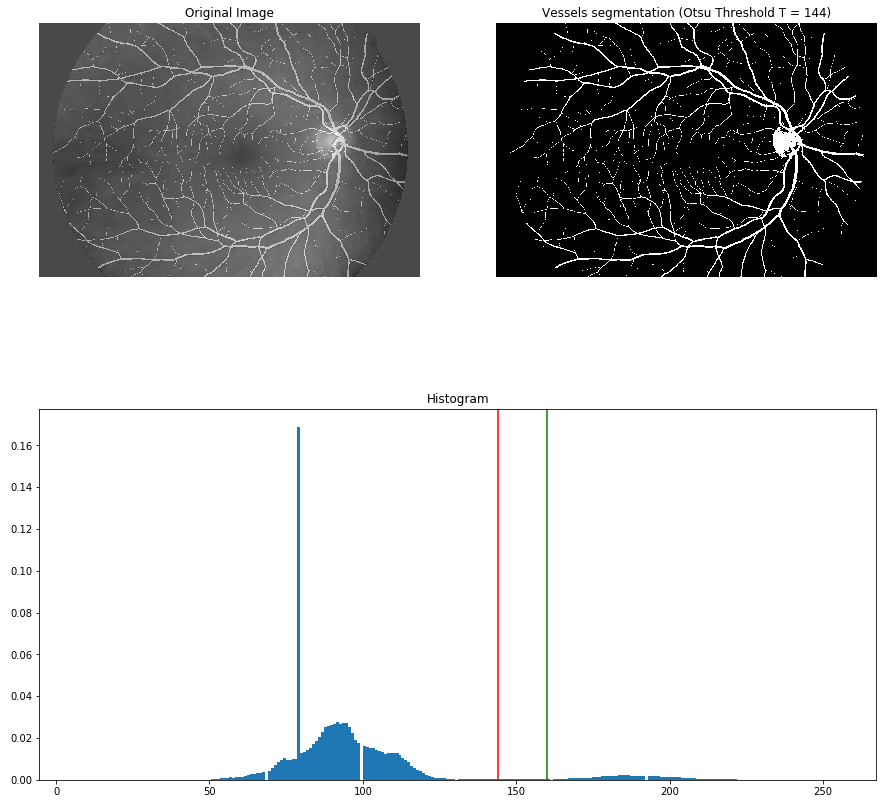

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from skimage.filters import threshold_otsu

# Find Otsu's threshold for training image:
threshold_otsu = threshold_otsu(I_train)

# Apply threshold to test image:
I_otsu = I_test >= threshold_otsu

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(I_test, cmap=plt.cm.gray)
ax1.set_title('Original Image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(I_otsu, cmap=plt.cm.gray)
ax2.set_title('Vessels segmentation (Otsu Threshold T = {})'.format(threshold_otsu))
ax2.set_axis_off()

ax3 = fig.add_subplot(gs[1,:])
ax3.hist(I_test.ravel(), bins=256,density=True)
ax3.axvline(threshold_otsu, color='r')
ax3.axvline(threshold_manual, color='g')
ax3.set_title('Histogram')
plt.show()

# Segmentation methods using clustering algorithms: 

Tehre are many Artificial Intelligence methods devoted to **automatic data clustering**. In our case clusters correspond to pixels belonging to the pattern and to the background. They are **Usupervised methods** that do not require the use of the ground truth in order to obtain a suitable segmentation. 

The most common ones arethe following: 

- Kmeans clustering
- Hierarchical clustering
- Gaussian Mixture models

We are going to focus in the kmeans clustering, we first explain how it works and then we are going to apply kmeans clustering to our vessel semgnetation problem. At the end of the section we provide some details on Hierarchical clustering and Gaussian Mixture models. 

## kmeans algorithm:

[1] Specify the number of clusters $k$ to be found in data.

[2] Set initial values for the cluster centroids $\mu^0_1,\dots,\mu^0_k$ (at random or prior knowledge). 

[3] Assign each observation to the nearest cluster (euclidean distance).

[4] Recompute the centroid of each cluster from the assigned observations $\mu^1_1,\dots,\mu^1_k$.

[5] Repeat steps 3-4 until no change in the centroids. Provide final clustering $\mu^n_1,\dots,\mu^n_k$, where $n$ is the number of iterations.

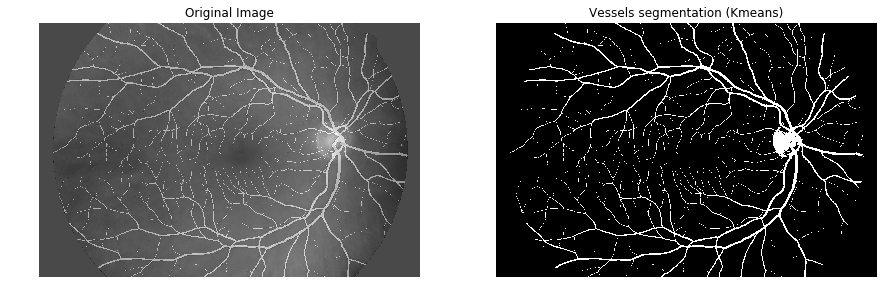

In [ ]:
from sklearn.cluster import KMeans

# reshape training image as 1d array:
v_I_train = I_train.reshape(I_train.shape[0]*I_train.shape[1],1).astype(np.uint8) 

# Fit a Kmeans clustering model with two clusters using training image:
kmeans = KMeans(n_clusters=2, random_state=0).fit(v_I_train)

# Apply to predict test image:
v_I_test = I_test.reshape(I_test.shape[0]*I_test.shape[1],1).astype(np.uint8) # reshape image as 1d array

v_kmeans = kmeans.predict(v_I_test)
v_kmeans= np.logical_not(v_kmeans)
I_kmeans = np.array(v_kmeans).reshape(I_test.shape[0],I_test.shape[1]).astype(np.uint8) # Shape back result as image 


fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(I_test, cmap=plt.cm.gray)
ax1.set_title('Original Image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(I_kmeans, cmap=plt.cm.gray)
ax2.set_title('Vessels segmentation (Kmeans)')
ax2.set_axis_off()

plt.show()

## Evaluating segmentation algorithms:

In order to evaluate a segmentation algorithm, we should introduce the following quantities:

- True positive (TP): A pattern pixel that has been correctly segmented as pattern
- True negative (TN): A background pixel that has been correctly segmented as background
- False positive (FP): A background pixel that has been mistakenly segmented as pattern (false alarm, Type I error)
- False negative (FN): A pattern pixel that has been mistakenly segmented as bavkground (omission, Type II error)

The confusion matrix is a 2x2 matrix reporting these four values: TP,TNFP,FN. 

From them we can define different measures of error: 

- Sensitivity, recall, hit rate, or true positive rate (TPR):

## $\text{TPR} =\frac{TP}{TP+FN}$

- Specificity, selectivity or true negative rate (TNR):

## $\text{TNR} =\frac{TN}{TN+FP}$

- The Sorensen-Dice similarity index: 

Measures the similarity between a segmentation mask and the ground truth mask by computing the F1 score
is the harmonic mean of precision and sensitivity:

$\text{DSC}={\frac {2TP}{2TP+FP+FN}}$.

Let's compute these magnitudes for each of the segmentation methods:

In [ ]:
from sklearn.metrics import confusion_matrix

v_test_GT = I_test_GT.reshape(I_test_GT.shape[0]*I_test_GT.shape[1],1).astype(np.bool) 

v_manual = I_manual.reshape(I_manual.shape[0]*I_manual.shape[1],1).astype(np.bool) 
CM_manual = confusion_matrix(v_test_GT,v_manual)
tn, fp, fn, tp = CM_manual.ravel()
TPR_manual = tp/(tp+fn)
FPR_manual = fp/(fp+tn)
DSC_manual = 2*tp/(2*tp+fp+fn)

v_otsu = I_otsu.reshape(I_otsu.shape[0]*I_otsu.shape[1],1).astype(np.bool) 
CM_otsu = confusion_matrix(v_test_GT,v_otsu)
tn, fp, fn, tp = CM_otsu.ravel()
TPR_otsu = tp/(tp+fn)
FPR_otsu = fp/(fp+tn)
DSC_otsu = 2*tp/(2*tp+fp+fn)

CM_kmeans = confusion_matrix(v_test_GT,np.array(v_kmeans).astype(np.bool))
tn, fp, fn, tp = CM_kmeans.ravel()
TPR_kmeans = tp/(tp+fn)
FPR_kmeans = fp/(fp+tn)
DSC_kmeans = 2*tp/(2*tp+fp+fn)

print('Manual Segmentation: TPR={}, FPR={}, DSC={}'.format(TPR_manual,FPR_manual,DSC_manual))
print('Otsu Segmentation: TPR={}, FPR={}, DSC={}'.format(TPR_otsu,FPR_otsu,DSC_otsu))
print('Kmeans Segmentation: TPR={}, FPR={}, DSC={}'.format(TPR_kmeans,FPR_kmeans,DSC_kmeans))

Manual Segmentation: TPR=0.9667002658719724, FPR=0.002368903147958446, DSC=0.9668264967980708
Otsu Segmentation: TPR=0.9967332077015222, FPR=0.00421710061861458, DSC=0.9697979184211555
Kmeans Segmentation: TPR=0.996066701726707, FPR=0.004090622950957041, DSC=0.9702966950770799


# Other clustering methods: 

## Hierarchical clustering, agglomerative clustering:


Sequence of partitions of the data into a set of clusters. They can be either agglomerative or Divisive: 

- Divisive: Start with all observations in one cluster and slplit the clusters sequencially.

- Agglomerative: Start with as many cluster as observations and group them according to a cluster to cluster distance (linkage). 

Consider two clusters $r$ and $s$ with $n_r$ and $n_s$ observations. A common cluster-cluster distances is: 

\begin{equation*}
d_{min}(r,s) = \min \{ d(x_i^r,x_j^s) \}, \, i=1,\dots,n_r ; j=1,\dots,n_s
\end{equation*}
where $d(x_i^r,x_j^s)$ is the euclidean distance between observation $i$ in cluster $r$ and $j$ in cluster $s$.

Other commonly used cluster-cluster distances are: 
\begin{eqnarray*}
d_{max}(r,s) &=& \max \{ d(x_i^r,x_j^s) \}, \, i=1,\dots,n_r ; j=1,\dots,n_s \\
d_{max}(r,s) &=& \frac{1}{n_s n_r}\sum_{i=1}^{n_r} \sum_{j=1}^{n_s} d(x_i^r,x_j^s) 
\end{eqnarray*}


The agglomerative clustering algorithm:

[1] Specify the number of clusters $k$ to be found in data.

[2] Initizlize the number of clusters to the number of observations $N$.  

[3] Group the nearest two clusters based on a cluster-to-cluster distance. 

[4] Recompute the centroid of each cluster from the assigned observations $\mu^1_1,\dots,\mu^1_{N-1}$.

[5] Repeat steps 3-4 until the number of clusters is $k$.  


## Gaussian Mixture Model Clustering

We model the distribution of the multidimensional observations using a mixture of gaussian distributions: 

$p(\vec{x}) = \sum_{i=1}^G \pi_i N(\vec{\mu_i},\Sigma)$

$\sum_{i=1}^G \pi_i, 0\le \pi_i \le 1$

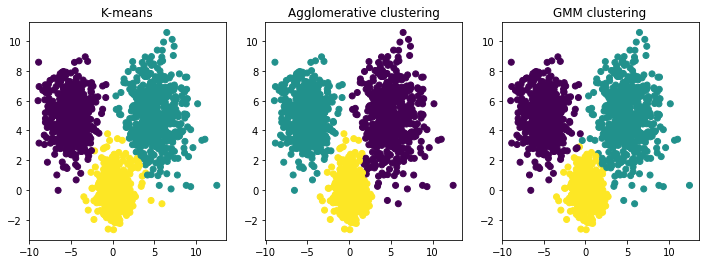

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn import mixture


n_clusters = 3
n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, centers=[[-5,5],[0,0],[5,5]], cluster_std = [1.5,1,2], n_features=2,random_state=random_state)

y_pred_kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit_predict(X)

fig = plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_kmeans)
plt.title("K-means")

clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(X)
y_pred_hier = clustering.fit_predict(X)

plt.subplot(132)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_hier)
plt.title("Agglomerative clustering")


gmm = mixture.GaussianMixture(n_components=n_clusters,covariance_type='full')
y_pred_gmm = gmm.fit_predict(X)

plt.subplot(133)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_gmm)
plt.title("GMM clustering")

plt.show()

# Supervised methods: 

## LINEAR DISCRIMINANT ANALYSIS (LDA)

The Bayes theorem in the context of data classification:
\begin{equation*}
p(\omega_i|\vec{x}) = \frac{p(\vec{x}|\omega_i) p(\omega_i)}{p(\vec{x})}
\end{equation*}
where $\vec{x} = \{x_1,\dots,x_d\}$ is an observation in a d-dimensional feature space and $\omega_i$ is a label for class $i$. 
Bayesian decision theory: Assign observation $\vec{x}$ to the class that maximizes the posterior probability $p(\omega_i|\vec{x})$:
\begin{equation*}
\text{argmax}_{i \in 1,\dots,G} p(\omega_i|\vec{x}) 
\end{equation*}

We define the discriminant function $g_i(\vec{x})$ as:
\begin{equation*}
g_i(\vec{x}) = \log p(\omega_i|\vec{x}) = \log p(\vec{x}|\omega_i) + \log p(\omega_i)
\end{equation*}

When all $G$ classes have equal prior probabilities $p(\omega_i)=1/G$, the Maximum a Posteriori decision is equivalent to a Maximum Likelihood since 
the posterior is proportional to the likelihood function $p(\omega_i|\vec{x}) \propto p(\vec{x}|\omega_i)$. 

Let's assume that observations $\vec{x}$ belonging to class $\omega_i$ are distributed according to a d-dimensional multivariate normal $N(\mu_i,\Sigma_i)$. The likelihood is then given by:
\begin{equation*}
p(\vec{x}|\omega_i) = \frac{1}{(2\pi)^{d/2} |\Sigma_i|^{1/2}} 
e{\frac{1}{2}(\vec{x}-\mu_i)^T \Sigma_i^{-1} (\vec{x}-\mu_i)}
\end{equation*}
%
and the discriminant function $g_i(\vec{x})$ is then given by:
%
\begin{equation*}
g_i(\vec{x}) = \log p(\omega_i|\vec{x}) = -\frac{d}{2}\log 2\pi -\frac{1}{2}\log|\Sigma_i| - \frac{1}{2}(\vec{x}-\mu_i)^T \Sigma_i^{-1} (\vec{x}-\mu_i)+\log p(\omega_i)
\end{equation*}

Multi-class supervised classification algorithm based on discriminant functions: 

[1] Construct a {\bf training set} of labeled observations $\mathcal{D}_i$ for each class $\omega_i, \, i=1,\dots,G$:

\begin{eqnarray*}
\mathcal{D}_i = \{\vec{x}_1,\dots,\vec{x}_N \}
\end{eqnarray*}

[2] Use training sets $\mathcal{D}_i, \, i=1,\dots,G$ to estimate the i-the class parameters $(\mu_i,\Sigma_i)$. 

[3] Classify a new unlabeled observation $\vec{x}_{new}$ to the class with maximum discriminant function:

\begin{equation*}
\text{argmax}_{i \in 1,\dots,G} g_i(\vec{x}_{new}) 
\end{equation*}


Train a LDA model using labelled pixels from training image (both training image and training ground truth):

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


v_train_GT = I_train_GT.reshape(I_train_GT.shape[0]*I_train_GT.shape[1],1).astype(np.bool) 

lda_model = LinearDiscriminantAnalysis()
lda_model.fit(v_I_train, v_train_GT.ravel())
LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [ ]:
lda_model.means_

array([[ 98.26450297],
       [194.12786525]])

Predict pixel classes in test image:

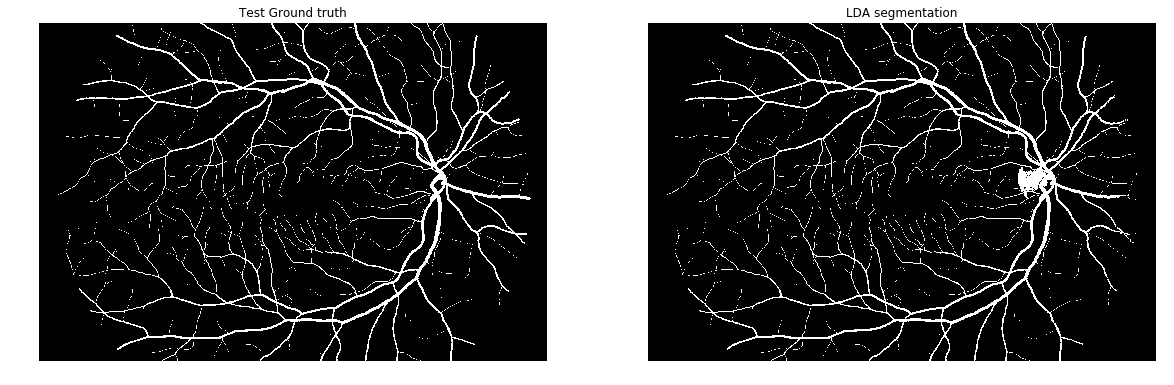

In [ ]:
v_lda = lda_model.predict(v_I_test)
I_lda = np.array(v_lda).reshape(I_test.shape[0],I_test.shape[1]).astype(np.uint8) # Shape back result as image 

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(20, 20))

ax[0].imshow(I_test_GT, cmap=plt.cm.gray)
ax[0].set_title('Test Ground truth')
ax[0].set_axis_off()

ax[1].imshow(I_lda, cmap=plt.cm.gray)
ax[1].set_title('LDA segmentation')
ax[1].set_axis_off()

plt.show()

In [ ]:
CM_lda = confusion_matrix(v_test_GT,np.array(v_lda).astype(np.bool))
tn, fp, fn, tp = CM_lda.ravel()
TPR_lda = tp/(tp+fn)
FPR_lda = fp/(fp+tn)
DSC_lda = 2*tp/(2*tp+fp+fn)

print('LDA Segmentation: TPR={}, FPR={}, DSC={}'.format(TPR_lda,FPR_lda,DSC_lda))

LDA Segmentation: TPR=0.9831237035089258, FPR=0.003014646271029858, DSC=0.970905651428659


Let's report all methods at once:

In [ ]:
print('Manual Segmentation: TPR={}, FPR={}, DSC={}'.format(TPR_manual,FPR_manual,DSC_manual))
print('Otsu Segmentation: TPR={}, FPR={}, DSC={}'.format(TPR_otsu,FPR_otsu,DSC_otsu))
print('Kmeans Segmentation: TPR={}, FPR={}, DSC={}'.format(TPR_kmeans,FPR_kmeans,DSC_kmeans))
print('LDA Segmentation: TPR={}, FPR={}, DSC={}'.format(TPR_lda,FPR_lda,DSC_lda))

Manual Segmentation: TPR=0.9667002658719724, FPR=0.002368903147958446, DSC=0.9668264967980708
Otsu Segmentation: TPR=0.9967332077015222, FPR=0.00421710061861458, DSC=0.9697979184211555
Kmeans Segmentation: TPR=0.996066701726707, FPR=0.004090622950957041, DSC=0.9702966950770799
LDA Segmentation: TPR=0.9831237035089258, FPR=0.003014646271029858, DSC=0.970905651428659


Conclusion: In this particular example, the best overall method in terms of maximum Dice's similarity index is the supervised approach LDA with a 

## $DSC=0.9709$

Generate a final figure with the results:

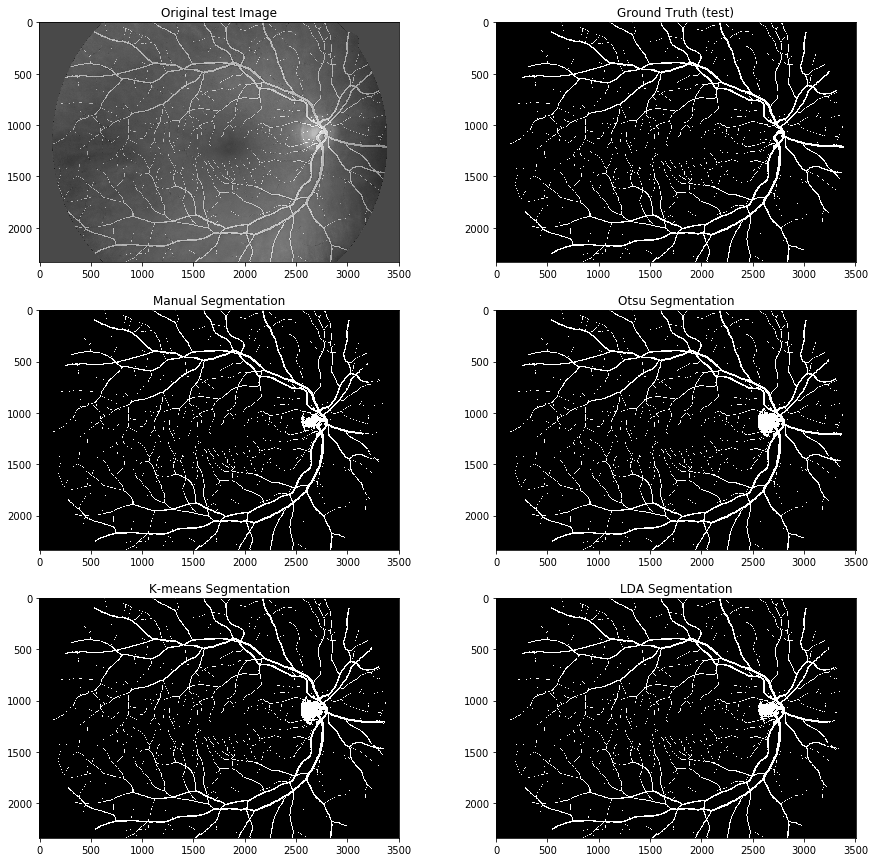

In [ ]:
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(3, 2)

ax0 = fig.add_subplot(gs[0,0])
ax0.imshow(I_test, cmap=plt.cm.gray)
ax0.set_title('Original test Image')

ax1 = fig.add_subplot(gs[0,1])
ax1.imshow(I_test_GT, cmap=plt.cm.gray)
ax1.set_title('Ground Truth (test)')

ax2 = fig.add_subplot(gs[1,0])
ax2.imshow(I_manual, cmap=plt.cm.gray)
ax2.set_title('Manual Segmentation')

ax3 = fig.add_subplot(gs[1,1])
ax3.imshow(I_otsu, cmap=plt.cm.gray)
ax3.set_title('Otsu Segmentation')

ax4 = fig.add_subplot(gs[2,0])
ax4.imshow(I_kmeans, cmap=plt.cm.gray)
ax4.set_title('K-means Segmentation')

ax5 = fig.add_subplot(gs[2,1])
ax5.imshow(I_lda, cmap=plt.cm.gray)
ax5.set_title('LDA Segmentation')

plt.savefig('Results.png')